# Sex prediction

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import sys

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer

sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import dataplotmelt
from utilities import test_model
from utilities import nested_crossvalidation
from utilities import nested_ROC_plot
from utilities import montecarlo_crossvalidation
from utilities import gridsearch_bias
from utilities import model_optimization


In [3]:
colors = sn.color_palette("Set2") 

In [4]:
tsetse_data = pd.read_csv("../data/raw/TseTse_finaldatasetclean.csv")

In [5]:
tsetse_data.rename(columns={"Cat1":"Plate", "Cat3":"Sex", "Cat4":"Age", "Cat5":"Tissue"}, inplace=True)
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("T", 'Thorax')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("H", 'Head')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("A", 'Abdomen')

In [6]:
tsetse_data_copy = tsetse_data.copy()

In [7]:
df_ic = pd.DataFrame(tsetse_data_copy.groupby(['Sex','Age','Tissue'])['ID'].count())
df_ic

ID
Sex Age Tissue      
f   3d  Abdomen   48
        Head     133
        Thorax   136
    5w  Abdomen   16
        Head      92
        Thorax    96
    7w  Abdomen   38
        Head     120
        Thorax   122
m   5w  Head      94
        Thorax    93
    7w  Abdomen   15
        Head      93
        Thorax    92

In [70]:
df_ic.to_excel("../results/tables/wholespectra_results/samples_summary.xlsx")

In [8]:
tsetse_data_sameages = tsetse_data[(tsetse_data["Age"]!= '3d')]
tsetse_data_sameages_copy = tsetse_data_sameages.copy()

## Sex prediction

In [9]:
tsetse_thorax = tsetse_data_sameages_copy.loc[tsetse_data_sameages_copy['Tissue'] == 'Thorax']
tsetse_head = tsetse_data_sameages_copy.loc[tsetse_data_sameages_copy['Tissue'] == 'Head']

In [10]:
tsetse_head.groupby("Sex")["ID"].count()

Sex
f    212
m    187
Name: ID, dtype: int64

In [11]:
X_thorax = tsetse_thorax.loc[:,"4000":"402"]
y_thorax = tsetse_thorax.loc[:,"Sex"]

X_head = tsetse_head.loc[:,"4000":"402"]
y_head = tsetse_head.loc[:,"Sex"]

In [12]:
waveNumslist = X_thorax.columns.values.tolist()
wavenumbers = [int(x) for x in waveNumslist]

In [21]:
y_thorax.value_counts()

Sex
f    218
m    185
Name: count, dtype: int64

## Bias test

In [22]:
X_thorax_part1 = X_thorax.loc[:,"4000":"402"]
X_thorax_part2 = X_thorax.loc[:,"1800":"600"]
X_thorax_part3 = X_thorax.loc[:,"3500":"2750"]
X_thorax_part4 = X_thorax.loc[:,"2750":"1800"]

X_thorax_desbiased = pd.concat([X_thorax_part3,X_thorax_part2],axis=1)

In [23]:
# thorax
bias_test_part1 = gridsearch_bias(X_thorax_part1,y_thorax)
bias_test_part2 = gridsearch_bias(X_thorax_part2,y_thorax)
bias_test_part3 = gridsearch_bias(X_thorax_part3,y_thorax)
bias_test_part4 = gridsearch_bias(X_thorax_part4,y_thorax)
bias_test_part5 = gridsearch_bias(X_thorax_desbiased,y_thorax)

In [56]:
result = pd.concat([bias_test_part1, bias_test_part2['mean_test_score'],bias_test_part3['mean_test_score'],bias_test_part4['mean_test_score'],bias_test_part5['mean_test_score']], axis=1)

result['Tissue'] = 'Thorax'


In [26]:
X_head_part1 = X_head.loc[:,"4000":"402"]
X_head_part2 = X_head.loc[:,"1800":"600"]
X_head_part3 = X_head.loc[:,"3500":"2750"]
X_head_part4 = X_head.loc[:,"2750":"1800"]

X_head_desbiased = pd.concat([X_head_part3,X_head_part2],axis=1)

y_head_sameage = y_head

In [27]:
bias_test_head_part1 = gridsearch_bias(X_head_part1, y_head_sameage)
bias_test_head_part2 = gridsearch_bias(X_head_part2, y_head_sameage)
bias_test_head_part3 = gridsearch_bias(X_head_part3, y_head_sameage)
bias_test_head_part4 = gridsearch_bias(X_head_part4, y_head_sameage)
bias_test_head_part5 = gridsearch_bias(X_head_desbiased, y_head_sameage)

In [58]:
result2 = pd.concat([bias_test_head_part1, 
    bias_test_head_part2['mean_test_score'],
    bias_test_head_part3['mean_test_score'],
    bias_test_head_part4['mean_test_score'],
    bias_test_head_part5['mean_test_score']], axis=1)
result2['Tissue'] = 'Head'


In [71]:
bias_sex = pd.concat([result2, result])
bias_sex.set_index("Tissue", inplace=True)

bias_sex.columns = ["Model", "kernel","D1","D2","D3","D4","D5"]

bias_sex


result.to_excel("../results/tables/wholespectra_results/biased_sex_pred.xlsx")

In [13]:
# permutation test

from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score

clf = SVC(kernel="linear", random_state=7)
cv = StratifiedKFold(2, shuffle=True, random_state=0)

score_iris, perm_scores_iris, pvalue_iris = permutation_test_score(
    clf, X_thorax, y_thorax, scoring="accuracy", cv=cv, n_permutations=1000)

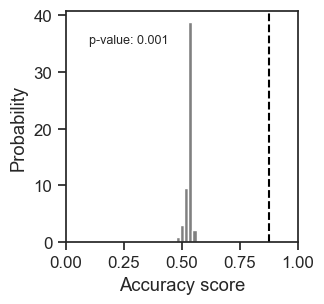

In [29]:
sn.set_context('notebook', font_scale=1.1)

fig, ax = plt.subplots(figsize=(3,3))
ax.hist(perm_scores_iris, density=True, color='grey')
ax.axvline(score_iris, ls="--", color="k")
score_label = f"p-value: {pvalue_iris:.3f}"
ax.text(0.1, 35, score_label, fontsize=9)
ax.set_xlabel("Accuracy score")
ax.set_ylabel("Probability")
ax.set_xlim(0,1)

plt.savefig("../results/plots/permutationtest_sex.png", dpi=300, bbox_inches='tight')


In [81]:
X_thorax.to_csv("../data/processed/X_thorax.csv", index=False)
y_thorax.to_csv("../data/processed/y_thorax_sex.csv", index=False)

# Sex predictioin

In [31]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_thorax, y_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_head, y_head, test_size=0.2, shuffle=True, random_state=123)

In [32]:
print(X_hd_train.shape)
print(X_hd_test.shape)

print(X_th_train.shape)
print(X_th_test.shape)

(319, 1800)
(80, 1800)
(322, 1800)
(81, 1800)


In [78]:
shape_data = {"train_head": y_hd_train.value_counts(),
              "train_thorax": y_th_train.value_counts(),
              "test_head": y_hd_test.value_counts(),
              "test_thorax":y_th_test.value_counts()}

In [79]:
shape_data_df = pd.DataFrame(shape_data)

shape_data_df

,train_head,train_thorax,test_head,test_thorax
Sex,,,,
f,166,166,46,52
m,153,156,34,29


In [80]:
shape_data_df.to_excel("../results/tables/wholespectra_results/train_test_shape_sex.xlsx")

In [35]:
thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [36]:
data_plot_thorax = dataplotmelt(thorax_acc_baseline)
data_plot_head = dataplotmelt(head_acc_baseline)

In [37]:
output = data_plot_head.groupby(['param_clf'], as_index=False).agg({'value':['mean','std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.871875  0.045881
1        LR  0.943750  0.023524
2        RF  0.903125  0.039528
3       SVC  0.909375  0.036681


In [38]:
output = data_plot_thorax.groupby(['param_clf'], as_index=False).agg({'value':['mean','std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.836923  0.041154
1        LR  0.935385  0.027900
2        RF  0.892308  0.034017
3       SVC  0.869231  0.037859


In [39]:
# model optimization

# Head
best_model_head = model_optimization(X_hd_train,y_hd_train)
# thorax
best_mdoel_thorax = model_optimization(X_th_train, y_th_train)

Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}
Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear'}


In [40]:
# test head

y_head_pred, y_head_prob, pipe_head = test_model(X_hd_train, X_hd_test, y_hd_train, best_model_head)
y_thorax_pred, y_thorax_prob, pipe_thorax = test_model(X_th_train, X_th_test, y_th_train, best_mdoel_thorax)

In [41]:
accuracy_head = accuracy_score(y_hd_test, y_head_pred)
accuracy_thorax = accuracy_score(y_th_test, y_thorax_pred)
print(f"Accuracy on test set using the head: {accuracy_head}")
print(f"Accuracy on test set suing the thorax: {accuracy_thorax}")

Accuracy on test set using the head: 0.9875
Accuracy on test set suing the thorax: 0.9382716049382716


In [81]:
report_head = classification_report(y_hd_test, y_head_pred, output_dict=True)
report_head = pd.DataFrame(report_head).transpose()
report_head["Tissue"] = "Head"
report_head

,precision,recall,f1-score,support,Tissue
f,0.978723,1.000000,0.989247,46.0000,Head
m,1.000000,0.970588,0.985075,34.0000,Head
accuracy,0.987500,0.987500,0.987500,0.9875,Head
macro avg,0.989362,0.985294,0.987161,80.0000,Head
weighted avg,0.987766,0.987500,0.987474,80.0000,Head


In [82]:
report_thorax = classification_report(y_th_test, y_thorax_pred, output_dict=True)
report_thorax = pd.DataFrame(report_thorax).transpose()
report_thorax["Tissue"] = "Thorax"
report_thorax

,precision,recall,f1-score,support,Tissue
f,0.979592,0.923077,0.950495,52.000000,Thorax
m,0.875000,0.965517,0.918033,29.000000,Thorax
accuracy,0.938272,0.938272,0.938272,0.938272,Thorax
macro avg,0.927296,0.944297,0.934264,81.000000,Thorax
weighted avg,0.942145,0.938272,0.938873,81.000000,Thorax


In [86]:
report_sex_prediction = pd.concat([report_head, report_thorax])

report_sex_prediction.to_excel("../results/tables/wholespectra_results/Accuracy_sex_report.xlsx")

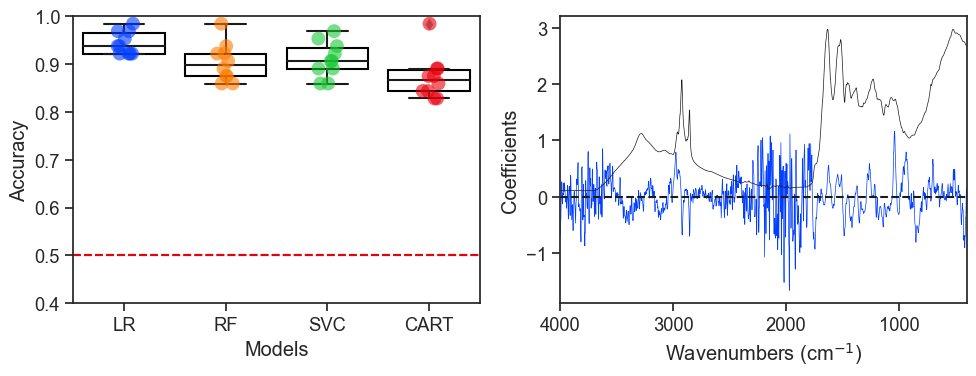

In [88]:
# plot

sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10,4), tight_layout=True)

sn.boxplot(data=data_plot_head, x='param_clf',y='value',ax=ax, color='white')
sn.stripplot(data=data_plot_head, x='param_clf',y='value',ax=ax,size=10, hue='param_clf', alpha=0.6, legend=False)
plt.setp(ax.lines, color='k')

for l, box in enumerate(ax.patches):
    box.set_edgecolor('black')

ax.axhline(0.5, color='r', ls='--')
ax.set_ylim(0.4,1)



sn.lineplot(x=wavenumbers, y=best_model_head['model'].coef_[0], ax=ax2, linewidth=0.5)


plots1 = [ax2]

for i in plots1:
    i.axhline(0, color='k', ls='--')
    sn.lineplot(x=wavenumbers, y=np.mean(X_hd_train, axis=0)*10, linewidth=0.5, color='k', ax=i)
    i.set_xlim(4000, 400)
    i.set_ylabel("Coefficients")
    i.set_xlabel("Wavenumbers (cm$^{-1}$)")


plots2 = [ax]
for i in plots2:
    i.axhline(0.5, color='r', ls='--')
    i.set_ylim(0.4,1)
    i.set_xlabel("Models")
    i.set_ylabel("Accuracy")


plt.savefig("../results/plots/sex_predicton_figure4.png", dpi=900, bbox_inches='tight')

## monte carlo cross validation


In [49]:
# monte carlo cross validation

accuracy_head_mc, sensitivity_head_mc, specificity_head_mc = montecarlo_crossvalidation(X_head, y_head, best_model_head)


shuffle split: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]

Model perfomance using monte carlo cross-validation
Mean accuracy = 0.96 ± 0.02


In [50]:
accuracy_thorax_mc, sensitivity_thorax_mc, specificity_thorax_mc = montecarlo_crossvalidation(X_thorax, y_thorax, best_mdoel_thorax)

shuffle split: 100%|██████████| 100/100 [00:29<00:00,  3.38it/s]

Model perfomance using monte carlo cross-validation
Mean accuracy = 0.94 ± 0.02


In [51]:
monte_carlo = pd.DataFrame({"Accuracy": [np.mean(accuracy_head_mc),
                                         np.mean(accuracy_thorax_mc)], 
                            "std":[np.std(accuracy_head_mc),
                                   np.std(accuracy_thorax_mc)], 
                            "Sensitivity":[np.mean(sensitivity_head_mc),
                                           np.mean(sensitivity_thorax_mc)],
                            "std_s": [np.std(sensitivity_head_mc),
                                           np.std(sensitivity_thorax_mc)],
                            "Specificity": [np.mean(specificity_head_mc),
                                          np.mean(specificity_thorax_mc)],
                            "std_sp": [np.std(specificity_head_mc),
                                          np.std(specificity_thorax_mc)]}, index=['head','thorax'])

In [52]:
monte_carlo

,Accuracy,std,Sensitivity,std_s,Specificity,std_sp
head,0.964500,0.022130,0.963112,0.029620,0.965252,0.030734
thorax,0.943704,0.022381,0.964027,0.033286,0.927500,0.033509


In [55]:
monte_carlo.to_excel("../results/tables/wholespectra_results/sex_prediction_mc.xlsx")